In [1]:
print('')

aim to plot change in gradient as consider changing minimum magntiude of data

In [2]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pickle
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import math

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [48]:
filenames = ['eq_object_03s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_05s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_1s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_4s_bandpass_01_19_snr_20_blank_0_new']

'''filenames = ['eq_object_03s_bandpass_01_19_snr_20_blank_0_new',
              'eq_object_03s_bandpass_01_19_snr_20_blank_005_new',
              'eq_object_03s_bandpass_01_19_snr_20_blank_01_new']

filenames = ['eq_object_05s_bandpass_01_19_snr_20_blank_0_new',
             'eq_object_05s_bandpass_01_19_snr_20_blank_005_new', 
             'eq_object_05s_bandpass_01_19_snr_20_blank_01_new',
             'eq_object_05s_bandpass_01_19_snr_20_blank_025_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_0_new', 
             'eq_object_1s_bandpass_01_19_snr_20_blank_005_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_01_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_025_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_05_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_0_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_005_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_01_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_025_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_05_new']'''

magnitudes = np.arange(3,8, 0.1)

In [28]:
def sort_tp_data(df, mag_lim = 0):
    list_tp_all = list(df.tp_max)
    list_mag_all = list(df.eq_mag)
    list_mag = []
    list_tpmax = []
    count = 0
    for m in range(0, len(list_mag_all)):
        if list_mag_all[m] > mag_lim:
            list_mag.append(list_mag_all[m])
            list_tpmax.append([])
            for d in range(0, len(list_tp_all[m])):
                if list_tp_all[m][d] != None and list_tp_all[m][d]>0:
                    list_tpmax[count].append(list_tp_all[m][d])
            count += 1
    return list_mag, list_tpmax

In [5]:
def plot_tpmax(title, mag_lim, list_mags, list_tpmax):
    params = []
    opacities = np.linspace(0.2,1,45)
    import matplotlib.pyplot as plt
    cs = ['midnightblue']
    #fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    y_aves_tp = []
    x_aves_tp = []
    count = 1
    eq_count = 0
    medians = [[] for _ in range(0, 45)]
    medians_of_medians = [[] for _ in range(0, 45)]
    n = 0
    median_absolute_deviation = []
    sum_absolute_deviation = []
    all_abs_deviation = []
    for n in [1]:#range(1, 10):#number of stations eq at least measured at
        med_for_ad = []
        mag_for_ad = []
        fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
        #for mag_lim in [3.]:#, 3.4, 4.0, 4.4]:#np.arange(3.0, 6.5, 0.1):
        y_aves_tp = []
        x_aves_tp = []
        for i  in range(0, len(list_mags)):
            if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                #if list_mags[i] >= 4 and list_mags[i]<=5:
                if len(list_tpmax[i])>=n:
                    mean_tp = np.mean(list_tpmax[i]) 
                    std_tp = np.std(list_tpmax[i]) 
                    y_tp = [] 
                    for j in list_tpmax[i]: 
                        if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                            y_tp.append(math.log(j, 10))
                        elif len(list_tpmax[i])==1:
                            y_tp.append(math.log(j, 10))
                    x_tp = np.zeros(len(y_tp))  
                    x_tp = x_tp + list_mags[i]
                    c = 0
                    if len(x_tp)>0:
                        if math.isnan(np.median(y_tp))==False:
                            axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 10, c = '#003f5c', marker = 'x', zorder =110, alpha = 0.5)
                    if math.isnan(np.median(y_tp))==False:  
                        y_aves_tp.append(np.median(y_tp))
                        x_aves_tp.append(list_mags[i])
        if len(y_aves_tp)>0:
            x_use = np.array(x_aves_tp) - 5
            y_use = np.array(y_aves_tp)

            print(len(x_aves_tp), len(y_aves_tp))
            count += 1
            x = x_use
            y = y_use
            x_unique = np.arange(-2,3,0.1)
            df_tp = pd.DataFrame(columns = x_unique)

            result = scipy.stats.linregress(x,y)
            a = result.slope
            b = result.intercept
            std_a = result.stderr
            std_b = result.intercept_stderr

            y_1 = (a+std_a)*x_unique + (b+std_b)
            y_2 = (a+std_a)*x_unique + (b-std_b)
            y_3 = (a-std_a)*x_unique + (b+std_b)
            y_4 = (a-std_a)*x_unique + (b-std_b)


            y_min_1sd = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
            y_max_1sd = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))

            y_1 = (a+2*std_a)*x_unique + (b+2*std_b)
            y_2 = (a+2*std_a)*x_unique + (b-2*std_b)
            y_3 = (a-2*std_a)*x_unique + (b+2*std_b)
            y_4 = (a-2*std_a)*x_unique + (b-2*std_b)

            y_min_2sd = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
            y_max_2sd = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))        

            #plt.scatter(x+np.random.uniform(-0.05, 0.05, len(x)),y, marker = 'x', color = 'k', s = 10, alpha = 0.5)
            axs.fill_between(x_unique, y_min_1sd, y_max_1sd, color = '#bc5090', alpha = 0.6, zorder = 100, label = '1sd')
            axs.fill_between(x_unique, y_min_2sd, y_max_2sd, color = '#ffa600', alpha = 0.6, zorder = 99, label = '2sd')
            popt = np.polyfit(x, y, 1)
            axs.plot(x_unique, popt[0]*x_unique+popt[1], color='#003f5c',zorder=102,label='{a:.2f}x+{b:.2f}\npearson r: {r:.4f}'.format(a=result.slope,b=result.intercept-5*result.slope,r=result.rvalue))
            axs.set_ylabel('log10(tpmax)')
            axs.set_xlabel('magnitude')   
            axs.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)
            axs.legend()
            #axs.set_ylim([-2,1])
            t = title.split('_')
            #axs.set_title(f'Predominant period, window = {t[2]}, blanked time = {t[-2][0]}.{t[-2][1:]}s')
            #plt.show()
            #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/all_data/tpmax/{title}/mag{mag_lim:.1f}.pdf', format = 'pdf')
            #plt.close()
            return result.rvalue


In [49]:
gradt, intercept, gradt_std, intercept_std = [],[],[],[]
pearson = []
spearman = []
spearman_p = []

eq_object_03s_bandpass_01_19_snr_20_blank_0_new
0.16852104992162112
eq_object_05s_bandpass_01_19_snr_20_blank_0_new
0.15558627556368546
eq_object_1s_bandpass_01_19_snr_20_blank_0_new
0.15625042010696025
eq_object_4s_bandpass_01_19_snr_20_blank_0_new
0.15507387623172594


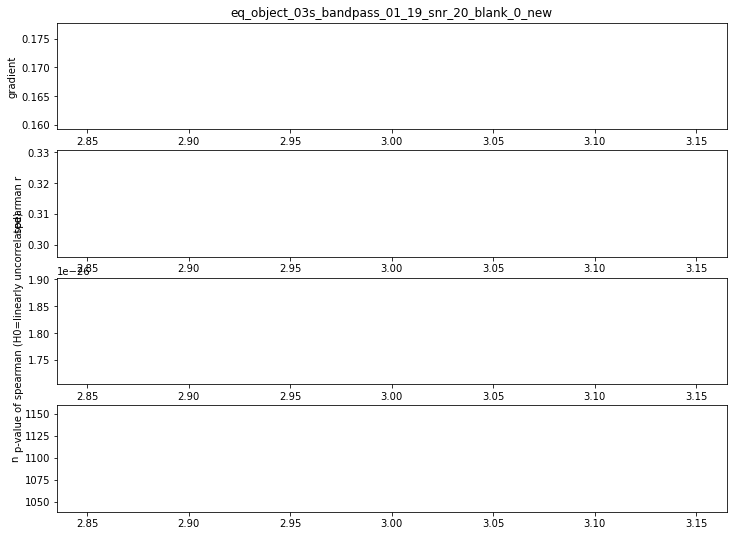

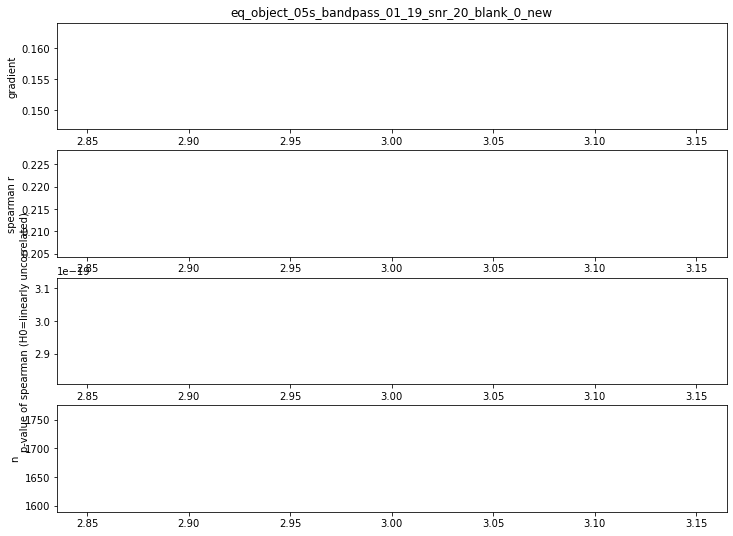

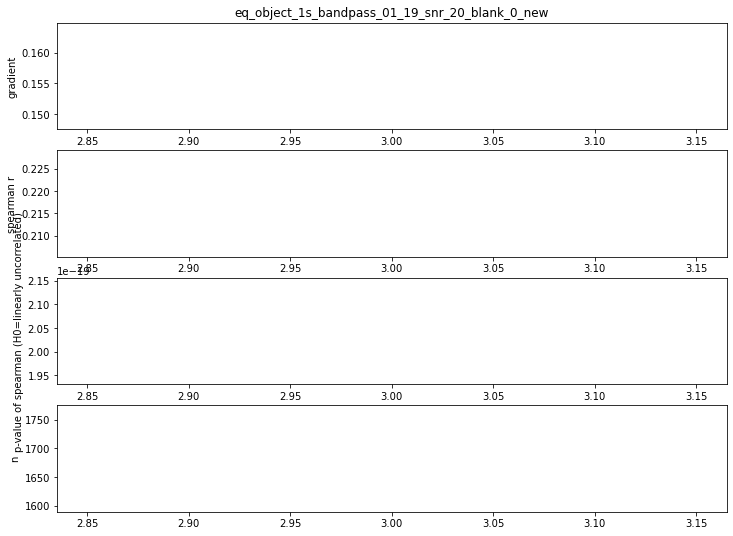

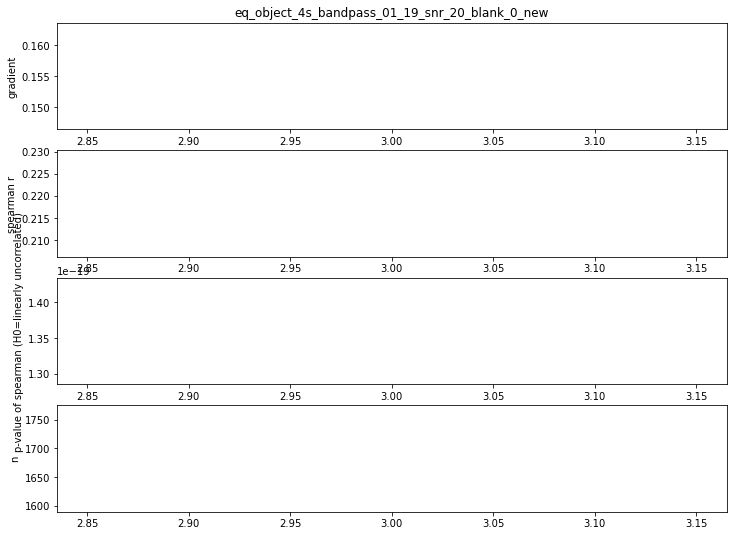

In [53]:
for f in filenames:
    print(f)
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        df = pd.read_pickle(f'/home/earthquakes1/homes/Rebecca/phd/data/results_database/{f}')
        list_mags, list_tpmax = sort_tp_data(df, mag_lim)
        #print(len(list_mags), len(list_tpmax))
        params = []
        opacities = np.linspace(0.2,1,45)
        cs = ['midnightblue']
        #fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
        y_aves_tp = []
        x_aves_tp = []
        count = 1
        eq_count = 0
        medians = [[] for _ in range(0, 45)]
        medians_of_medians = [[] for _ in range(0, 45)]
        n = 0
        median_absolute_deviation = []
        sum_absolute_deviation = []
        all_abs_deviation = []
        for n in [1]:#number of stations eq at least measured at
            med_for_ad = []
            mag_for_ad = []

            y_aves_tp = []
            x_aves_tp = []
            for i  in range(0, len(list_mags)):
                if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                    if len(list_tpmax[i])>=n:
                        mean_tp = np.mean(list_tpmax[i]) 
                        std_tp = np.std(list_tpmax[i]) 
                        y_tp = [] 
                        for j in list_tpmax[i]: 
                            if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                                y_tp.append(math.log(j, 10))
                            elif len(list_tpmax[i])==1:
                                y_tp.append(math.log(j, 10))
                        x_tp = np.zeros(len(y_tp))  
                        x_tp = x_tp + list_mags[i]
                        c = 0
                        #if len(x_tp)>0:
                            #if math.isnan(np.median(y_tp))==False:
                                #axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 10, c = '#003f5c', marker = 'x', zorder =110, alpha = 0.5)
                        if math.isnan(np.median(y_tp))==False:  
                            y_aves_tp.append(np.median(y_tp))
                            x_aves_tp.append(list_mags[i])
            if len(y_aves_tp)>0:
                x_use = np.array(x_aves_tp) - 5
                y_use = np.array(y_aves_tp)

                #print(len(x_aves_tp), len(y_aves_tp))
                count += 1
                x = x_use
                y = y_use
                x_unique = np.arange(-2,3,0.1)
                df_tp = pd.DataFrame(columns = x_unique)

                if len(set(x))>1:
                    result = scipy.stats.linregress(x,y)
                    a = result.slope
                    print(a)
                    gradt.append(a)
                    b = result.intercept
                    intercept.append(b)
                    std_a = result.stderr
                    gradt_std.append(std_a)
                    std_b = result.intercept_stderr
                    intercept_std.append(std_b)

                    pearson.append(result.rvalue)
                    spearman.append(scipy.stats.spearmanr(x,y)[0])
                    spearman_p.append(scipy.stats.spearmanr(x,y)[1])
                    n_l.append(len(x))

    fig, axs = plt.subplots(4,1, figsize = (12,9))
    axs[0].plot(magnitudes[0:len(spearman)],gradt)
    axs[0].set_ylabel('gradient')
    axs[1].plot(magnitudes[0:len(spearman)],spearman)
    axs[1].set_ylabel('spearman r')
    axs[2].plot(magnitudes[0:len(spearman)],spearman_p)
    axs[2].set_ylabel('p-value of spearman (H0=linearly uncorrelated)')
    axs[3].plot(magnitudes[0:len(spearman)],n_l)
    axs[3].set_ylabel('n')
    axs[0].set_title(f)
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/gradt_spearman/with_number_{f}.pdf', dpi=400)

In [43]:
df

,level_0,index,eq_id,eq_mag,eq_mag_type,eq_time,eq_loc,tp_max,tp_max_stations,tc,tc_stations,iv2,iv2_distances,iv2_stations,pgd,pgd_distances,pgd_stations
0,0,0,2110129,5.00,MW,20050131_173151,"(-41.6009, 175.838, 19.9)",[0.4606962267009088],[NZ.MRZ.10],[0.768408925896367],[NZ.MRZ.10],[],[],[],[1.3451628086966427e-06],[106.68083076278864 km],[NZ.MRZ.10]
1,1,0,2011699,5.30,MW,20050120_185630,"(-41.1222, 174.9773, 39.7)",[0.4266870798499702],[NZ.MRZ.10],[0.5625841278210169],[NZ.MRZ.10],[],[],[],[6.908218325359217e-06],[72.07969998851411 km],[NZ.MRZ.10]
2,2,0,2000953,5.00,MW,20050118_092558,"(-41.5413, 175.8527, 21.0)",[1.7511894768721439],[NZ.MRZ.10],[0.4975850948699407],[NZ.MRZ.10],[],[],[],[1.4463676836587953e-06],[100.4879719628321 km],[NZ.MRZ.10]
3,3,0,2000808,5.20,MW,20050118_083600,"(-41.6055, 175.8911, 9.2)","[1.558181510007831, 1.1656885463505207]","[NZ.BFZ.10, NZ.MRZ.10]","[0.9134682184359965, 3.5271103669283184]","[NZ.BFZ.10, NZ.MRZ.10]",[],[],[],"[2.2358515086266336e-06, 1.5862808022508744e-06]","[107.05746146962363 km, 108.1752118389166 km]","[NZ.BFZ.10, NZ.MRZ.10]"
4,4,0,1947713,5.00,MW,20050204_091538,"(-37.922, -73.3985, 22.8)","[0.4191753547996707, 0.40940317990063413, 0.27...","[ZW.A401., ZW.A402., ZW.A403., ZW.A404., ZW.A4...","[0.2990792573731163, 0.2432871338577274, 0.292...","[ZW.A401., ZW.A402., ZW.A403., ZW.A404., ZW.A4...",[],[],[],"[2.984485438230349e-06, 4.8596284720950816e-05...","[46.52436835522224 km, 45.99021789372439 km, 3...","[ZW.A401., ZW.A402., ZW.A403., ZW.A406., ZW.A4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,2318,0,11140120,4.10,mb,20191101_234328,"(-29.1792, -71.8827, 37.04)","[2.1223653960054927, 0.2467675380740236]","[C1.AC04., C1.CO10.]","[2.385423974757786, 0.29058375675459186]","[C1.AC04., C1.CO10.]",[],[],[],"[9.05359705046551e-07, 2.5869818508964764e-05]","[133.8459329456974 km, 41.57949818031772 km]","[C1.AC04., C1.CO10.]"
4433,2319,0,11139880,5.30,Mww,20191101_152412,"(11.5712, -86.7909, 50.02)","[1.579408618923122, 0.9599298495579663, 1.5285...","[NU.CNGN., NU.CRIN., NU.HERN., NU.NANN.]","[2.4782223144615236, 1.3037756084787688, 1.497...","[NU.CNGN., NU.CRIN., NU.HERN., NU.NANN.]",[],[],[],"[1.0341009384644005e-05, 0.00023046047717655612]","[128.0167604106423 km, 83.56438721336707 km]","[NU.CRIN., NU.NANN.]"
4434,2320,0,11139830,3.55,Mw,20191101_093317,"(36.568833, -117.976, 10.79)","[0.7219045391363624, 0.22270238905129972, 0.37...","[CI.CGO., CI.CWC., NN.DSP., CI.FUR., CI.GRA., ...","[0.22439935379917977, 0.11440021609478028, 0.2...","[CI.CGO., CI.CWC., NN.DSP., CI.FUR., CI.GRA., ...",[],[],[],"[2.1152929761349745e-05, 8.478855296329213e-06...","[15.62630164052065 km, 17.177205341114774 km, ...","[CI.CGO., CI.CWC., NN.DSP., CI.FUR., CI.GRA., ..."
4435,2321,0,11139801,3.20,ML,20191101_070002,"(39.137, -119.6248, 8.2)","[0.17066622598607115, 2.0437194125730938]","[NN.PNT., NN.WAK.]","[0.18412799448594222, 0.27760496888501657]","[NN.PNT., NN.WAK.]",[],[],[],"[3.0381959013278173e-05, 4.436633034633804e-07]","[5.743782441809731 km, 72.08248024187326 km]","[NN.PNT., NN.WAK.]"


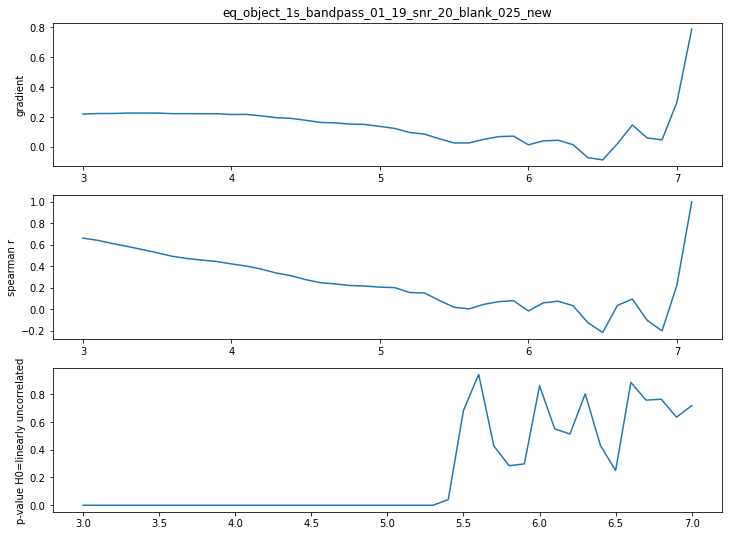

In [25]:
fig, axs = plt.subplots(3,1, figsize = (12,9))
axs[0].plot(magnitudes[0:47],gradt)
axs[0].set_ylabel('gradient')
axs[1].plot(magnitudes[0:47],spearman)
axs[1].set_ylabel('spearman r')
axs[2].plot(magnitudes[0:47],spearman_p)
axs[2].set_ylabel('p-value H0=linearly uncorrelated')
axs[0].set_title(f)
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/gradt_spearman/{f}.pdf', dpi=400)

In [44]:
list_mags

[7.8, 7.8]